In [31]:
%load_ext autoreload
%autoreload 2
import torch
import eq
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import trange, tqdm

from torch.utils.tensorboard import SummaryWriter
import datetime

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
print(eq.data.default_catalogs_dir)

/home/gcl/RA/zekai.wang/recast/data


In [33]:
catalog = eq.catalogs.ANSS_MultiCatalog(num_sequences=10000,
    t_end_days=4*365,
    mag_completeness=4.5,
    minimum_mainshock_mag=6.0,)

Loading existing catalog from /home/gcl/RA/zekai.wang/recast/data/ANSS_MultiCatalog.


/home/gcl/RA/zekai.wang/recast/eq/data/sequence.py:213: UserWarning: Found 1 zero inter-event times in the sequence. This violates fundamental assumptions of TPP models and may lead to incorrect log-likelihood values.
  warnings.warn(


In [34]:
print("Train sequence:")
print(catalog.train[0])
print("\nValidation sequence:")
print(catalog.val[0])
print("\nTest sequence:")
print(catalog.test[0])

Train sequence:
Sequence(
  inter_times: [300],
  arrival_times: [299],
  t_start: 0.0,
  t_end: 1460.0,
  t_nll_start: 0.0,
  mag: [299],
  mag_bounds: [2],
  mag_nll_bounds: [2]
)

Validation sequence:
Sequence(
  inter_times: [138],
  arrival_times: [137],
  t_start: 0.0,
  t_end: 843.909,
  t_nll_start: 0.0,
  mag: [137],
  mag_bounds: [2],
  mag_nll_bounds: [2]
)

Test sequence:
Sequence(
  inter_times: [2445],
  arrival_times: [2444],
  t_start: 0.0,
  t_end: 1460.0,
  t_nll_start: 0.0,
  mag: [2444],
  mag_bounds: [2],
  mag_nll_bounds: [2]
)


<Axes: xlabel='Time (days)', ylabel='Magnitude'>

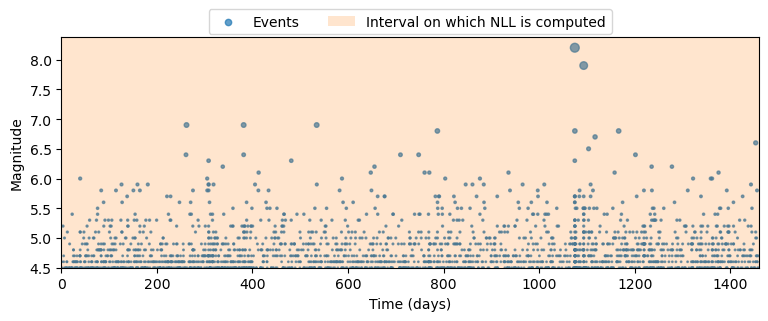

In [35]:
eq.visualization.visualize_sequence(catalog.test[0], show_nll=True)

## Training the model

In [80]:
batch_size = 1
dl_train = catalog.train.get_dataloader(batch_size=batch_size)
dl_val = catalog.val.get_dataloader(batch_size=batch_size)
dl_test = catalog.test.get_dataloader(batch_size=batch_size)

In [81]:
gpu_number = 0
device = torch.device(f"cuda:{gpu_number}")
print(f"using {device}")

using cuda:0


In [82]:
model = eq.models.RecurrentTPP_Attention()
model = model.to(device)

In [83]:
print(model)

RecurrentTPP_Attention(
  (hypernet_time): Linear(in_features=32, out_features=96, bias=True)
  (hypernet_mag): Linear(in_features=32, out_features=1, bias=True)
  (rnn): GRU(2, 32, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (multihead_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
  )
)


In [84]:
epochs = 100
avg_train_loss_list =[]
avg_val_loss_list = []

effective_batch_size = 32
M = effective_batch_size // batch_size

optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)
optimizer.zero_grad()

now = datetime.datetime.now()
writer = SummaryWriter(f"experiments/recurrent_attention_{now}")

num_train_iters_in_one_epoch = len(dl_train)

for epoch in trange(epochs):
    running_training_loss = []
    model.train()
    for i, data in enumerate(tqdm(dl_train)):
        data = data.to(device)
        nll = model.nll_loss(data).mean() / M
        nll.backward()
        running_training_loss.append(nll.item())
        writer.add_scalar("training_loss_per_step", nll.item(), i + epoch * num_train_iters_in_one_epoch)
        for name, param in model.named_parameters():
            if param.grad is not None:
                writer.add_scalar(f"{name}_accumulated_gradient_norm_per_step", torch.norm(param.grad).item(), i + epoch * num_train_iters_in_one_epoch)

        if i % M == M - 1:
            optimizer.step()
            optimizer.zero_grad()
        
    model.eval()
    with torch.no_grad():
        running_val_loss = []
        for i, data in enumerate(dl_val):
            data = data.to(device)
            nll = model.nll_loss(data).mean()
            running_val_loss.append(nll.item())

    avg_train_loss_list.append(np.mean(running_training_loss))
    avg_val_loss_list.append(np.mean(running_val_loss))
    writer.add_scalar("avg_training_loss_per_epoch", np.mean(running_training_loss), epoch)
    writer.add_scalar("avg_validation_loss_per_epoch", np.mean(running_val_loss), epoch)
writer.close()

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

ValueError: Expected parameter scale (Tensor of shape (1, 1688, 32)) of distribution Weibull(scale: torch.Size([1, 1688, 32]), shape: torch.Size([1, 1688, 32])) to satisfy the constraint GreaterThan(lower_bound=0.0), but found invalid values:
tensor([[[1.0095, 0.9823, 0.6100,  ..., 0.4930, 2.9873, 1.8256],
         [   nan,    nan,    nan,  ...,    nan,    nan,    nan],
         [   nan,    nan,    nan,  ...,    nan,    nan,    nan],
         ...,
         [   nan,    nan,    nan,  ...,    nan,    nan,    nan],
         [   nan,    nan,    nan,  ...,    nan,    nan,    nan],
         [   nan,    nan,    nan,  ...,    nan,    nan,    nan]]],
       device='cuda:0', grad_fn=<SoftplusBackward0>)

In [15]:
model.eval()
with torch.no_grad():
    running_test_loss = []
    for i, data in enumerate(dl_test):
        data = data.to(device)
        nll = model.nll_loss(data).mean()
        running_test_loss.append(nll.item())
print(f"avg test loss: {np.mean(running_test_loss)}")

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


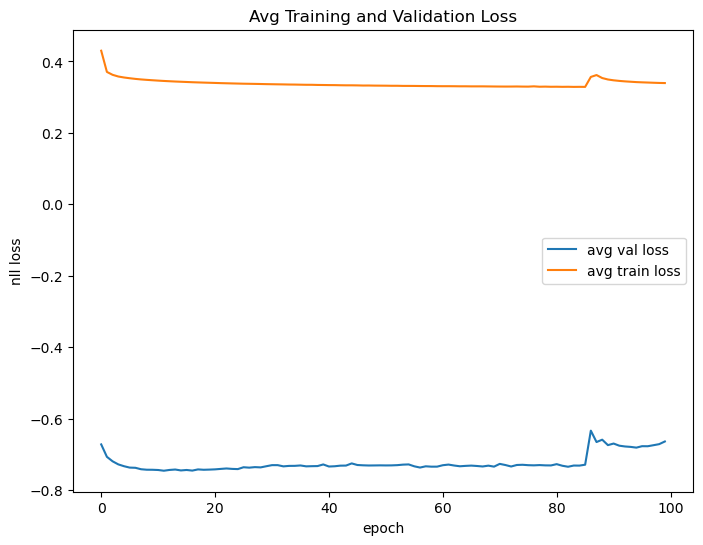

In [72]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(np.arange(0, epochs), avg_val_loss_list, label="avg val loss")
ax.plot(np.arange(0, epochs), avg_train_loss_list, label="avg train loss")
ax.set_xlabel("epoch")
ax.set_ylabel("nll loss")
ax.legend()
ax.set_title("Avg Training and Validation Loss")
plt.show()